In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.special import gamma, binom
from scipy.sparse import diags, kron, block_diag
from scipy.sparse.linalg import spsolve
from scipy.optimize import fsolve
from scipy.linalg import lstsq
from pathlib import Path
import time
import json


import datetime

def compute_classical_energy(u, eps, h):
    """Compute the discrete energy :

    Parameters
    ----------
    u : 2D-array
        The numerical solution of u.
    eps : float
        The diffusion coefficient.
    h : float
        The mesh size of x and y direction.

    Returns
    -------
    float
        The discrete energy of u.
        
    """
    
    ux = np.gradient(u)/h
    term1 = np.sum((eps**2 / 2.0) * (ux**2))
    term2 = np.sum(((1 - u ** 2) ** 2) / 4)
    return h * (term1 + term2)

def set_coef(terminate_point, alpha, method='L1'):
    """Set the coefficient of fractional scheme:

    Parameters
    ----------
    terminate_point : int
        The number of coefficient.
    alpha : float
        The fractional order between (0,1).
    method : str 
        The coefficient of scheme to generate.
        (defualt is 'L1')
        possible options : 'L1', 'GL'.

    Returns
    -------
    1D array
        The coefficient array generated 
        based on the selected method.
        
    """
    
    if method == 'L1':
        coef = [(j)**(1-alpha) - (j-1)**(1-alpha) \
                for j in range(1, terminate_point+1)]
    elif method == 'GL':
        coef = [(-1)**(j) * binom(alpha, j) \
                for j in range(0, terminate_point+1)]
        
    return np.array(coef)

def set_Laplacian2D(Nx, h, BC='periodic'):
    """Set the 2D discrete laplacian by central difference:
        Neumann boundary laplacian is discreted by 
        
        x-direction : u_{-1,j,k}=u_{0,j,k} and
                      u_{Nx+1,j,k}=u_{0,j,k}
                          
        y-direction : u_{i,-1,k}=u_{i,0,k} and
                      u_{i,Nx+1,k}=u_{i,0,k}
            
        Built by two block matries and two off-diagnoals, 
        corner block (corB), central block (cenB)
            
        The diagonal block is [corB, cenB, ..., cenB, corB]
        The off-diagnoals are diagonals line below (above) 
        the main diagonal by Nx positions, all consisting of 1.
            
        L = diagonal block + off-diagonals

    Parameters
    ----------
    Nx : int
        The number of mesh grids.
    h : float
        The mesh size.
    BC : str
        The boundary condition. (default is 'periodic')
        possible options : 'periodic', 'nuemann'

    Returns
    -------
    2D array
        The discrete laplacian with certain boundary.
        
    """
    if BC == 'periodic':
        diag = np.ones(Nx-1)
        L = diags([diag, -2*diag, diag, 1, 1], \
                  [-1, 0, 1 , -Nx+1, Nx-1], shape=(Nx-1, Nx-1))
        I = diags(diag, shape=(Nx-1, Nx-1))
    
        L = kron(L, I) + kron(I, L)
        
    elif BC == 'neumann':
        # bulid the block
        diag_cor = 3*np.ones(Nx)
        diag_cor[0] = diag_cor[-1] = 2

        diag_cen = 4*np.ones(Nx)
        diag_cen[0] = diag_cen[-1] = 3

        off_I = diags([np.ones(Nx**2), np.ones(Nx**2)], \
                      [Nx,-Nx], shape=(Nx**2, Nx**2))

        corB = diags([np.ones(Nx), -diag_cor, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        cenB = diags([np.ones(Nx), -diag_cen, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        diagBs = [cenB for i in range(Nx-2)]
        diagBs = tuple([corB]+diagBs+[corB])

        L = block_diag(diagBs) + off_I
        
    return L / h**2

In [34]:
# set the inital input
alpha_list = [0.1, 0.3, 0.5,  0.7, 0.9, 1]
BC = 'periodic'

L = 10
eps = 0.1

Nx = 2**7
x = np.linspace(-L/2, L/2, Nx) 
y = np.linspace(-L/2, L/2, Nx)

h = L / (Nx - 1)
dt = 5*1e-3
iter_max = 3000

# set the discrete laplacian
Lap = set_Laplacian2D(Nx, h, BC)

if BC == 'periodic':
    x = x[:-1]
    y = y[:-1]
    I = diags(np.ones((Nx-1)**2), shape=((Nx-1)**2, (Nx-1)**2))
elif BC == 'neumann':
    I = diags(np.ones((Nx)**2), shape=((Nx)**2, (Nx)**2))

# set the 2D mesh grid by x and y
X, Y = np.meshgrid(x, y)


info_dict = {
    'Nx': Nx,
    'dt': dt,
    'iteration': iter_max,
    'eps': eps
}


TotalRandNum = 50


start = datetime.datetime.now()

for _ in range(TotalRandNum):

    # nonsmooth test
    u = 0.05*(2*np.random.rand(Nx-1, Nx-1)-1)

    # smooth test
    # u = np.tanh((1-((X)**2+(Y)**2))/5)*0.2

    # turn 2D array into 1D array
    u0 = u.flatten()


    # the dicitionary to storage the different fractional order results
    data_dict = {}

    # set a figure to plot the energy in different alpha
    fig = plt.figure(figsize=(15,8))

    for alpha in alpha_list:
    
        # inital the history array
        u_historyArray = u0
        u = u0
    
        if alpha == 1:
            # solved by classical allen cahn
            H = (2+1/dt) * I - eps**2 * Lap
        
            for i in range(iter_max):
                b = (3+1/dt)*u - u**3
                u = spsolve(H, b)
                u_historyArray = np.vstack([u_historyArray, u])
        
        else:
            L1_coef = set_coef(iter_max, alpha, 'L1')/ dt**alpha / gamma(2-alpha)
            H = (L1_coef[0]+2) * I - eps**2 * Lap
        
            for i in range(iter_max):
                if i == 0: # first iteration u_1
                    b =  (3 + L1_coef[0])*u - u**3
                    u = spsolve(H, b)
                else:
                    u_nonlocalDiff = np.flipud(np.diff(u_historyArray, axis=0))
                    u_nonlocal = L1_coef[1:i+1].dot(u_nonlocalDiff)
        
                    b = (3 + L1_coef[0])*u - u**3 - u_nonlocal
                    u = spsolve(H, b)
            
                u_historyArray = np.vstack([u_historyArray, u])
    
        data_dict[alpha] = u_historyArray
    
    # set the mass array
    DifferenceMass = []
    for alpha in alpha_list:
        mass = [np.sum(_) for _ in np.diff(data_dict[alpha], axis=0)]
        DifferenceMass.append(mass)
    
    DifferenceMass = np.column_stack(DifferenceMass)
    
    
    # check what kind of the DifferenceMass array
    # all positive, all negative, or consist of positive and negative
    if np.all(DifferenceMass<0):
        DiffMassType = 'negative'
    elif np.all(DifferenceMass>0):
        DiffMassType = 'positive'
    else:
        DiffMassType = 'others'
    
    ts = str(time.time())
    rootPath = Path('./data/coarsening') / DiffMassType / ts

    if rootPath.exists() is False:
        rootPath.mkdir(parents=True)

    for alpha, u_historyArray in data_dict.items():
        dataPath = rootPath / f'L1_{alpha}_coarsening.npy'
        np.save(dataPath, u_historyArray)
    
    
    # save fig
    plt.figure(figsize=(12,5))
    plt.title(r'Total mass of $U_{k+1}-U_k$')
    plt.xlabel('k')
    plt.ylabel(r'$\mathbf{1}^T(U_{k+1}-U_k)$')
    plt.plot(DifferenceMass)
    plt.legend([rf"$\alpha=${alpha}" for alpha in alpha_list])
    
    figPath = rootPath / f'{DiffMassType}.png'
    plt.savefig(figPath)
    plt.close()
    
    infoPath = rootPath / 'info.json'
    infoPath.write_text(json.dumps(info_dict))
    
    

    
end = datetime.datetime.now()

print("執行時間：", end - start)

C:\Users\user\AppData\Local\Temp\ipykernel_10600\623808805.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,5))
C:\Users\user\AppData\Local\Temp\ipykernel_10600\623808805.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(15,8))


執行時間： 1 day, 19:56:34.395618


<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [27]:
for alpha in alpha_list:
    mass = [np.sum(_) for _ in np.diff(data_dict[alpha], axis=0)]
    print(mass)
    print("\n")

[0.41248086126155525, 0.41764281482760574, 0.3984728436145757, 0.3742005784947164, 0.3506852180344844, 0.3295419791467038, 0.31100837606670395, 0.29488868312384553, 0.2808762811913347, 0.26866373931922616, 0.257977363768195, 0.2485843798850252, 0.24029051825013528, 0.2329347468956449, 0.2263836884194976, 0.22052660564996235, 0.21527118385046842, 0.2105400878959046, 0.20626819040369268, 0.2024003517509624, 0.19888964298335357, 0.19569592006922007, 0.1927846756667817, 0.19012611004877109, 0.18769437549869328, 0.18546695853401113, 0.18342417214045834, 0.18154873625836523, 0.17982542943597044, 0.17824079817400687, 0.17678291327965978, 0.17544116471931612, 0.17420608815392907, 0.17306921767011613, 0.1720229602677603, 0.17106048849513558, 0.17017564828371162, 0.16936287956382368, 0.1686171476680274, 0.167933883872653, 0.1673089337071931, 0.1667385118885592, 0.1662191629234663, 0.1657477265752592, 0.16532130751773427, 0.16493724860302922, 0.16459310725768303, 0.16428663459329143, 0.1640157568

In [16]:
np.all(a<0)

True

In [8]:
rootPath = Path('./data/')
rootPath

WindowsPath('data')

In [9]:
rootPath / 'OK'

WindowsPath('data/OK')

In [54]:
# set the inital input
alpha_list = [0.1, 0.3, 0.5,  0.7, 0.9]
BC = 'periodic'

L = 10
eps = 0.1

Nx = 2**7
x = np.linspace(-L/2, L/2, Nx) 
y = np.linspace(-L/2, L/2, Nx)

h = L / (Nx - 1)
dt = 5*1e-3
iter_max = 3000

# set the discrete laplacian
Lap = set_Laplacian2D(Nx, h, BC)

if BC == 'periodic':
    x = x[:-1]
    y = y[:-1]
    I = diags(np.ones((Nx-1)**2), shape=((Nx-1)**2, (Nx-1)**2))
elif BC == 'neumann':
    I = diags(np.ones((Nx)**2), shape=((Nx)**2, (Nx)**2))

# set the 2D mesh grid by x and y
X, Y = np.meshgrid(x, y)

initialName = 'coarsening'

signType = 'negative'

rootPath = Path('./data/') / initialName / signType

dataPath = [folder for folder in rootPath.iterdir() \
            if not folder.name[0].startswith('.')]

for folder in dataPath:
    print(folder)
    
    for alpha in alpha_list:
        print(f"alpha: {alpha}")
        u_hist = np.load(folder / f'L1_{alpha}_{initialName}.npy')
        u0 = u_hist[0].copy()
        u = u0.copy()
        
        del u_hist
        gc.collect()
        
        u_historyArray = u0
        
        if alpha == 1:
            # solved by classical allen cahn
            H = (2+1/dt) * I - eps**2 * Lap
        
            for i in range(iter_max):
                b = (3+1/dt)*u - u**3
                u = spsolve(H, b)
                u_historyArray = np.vstack([u_historyArray, u])
        else:
            GL_coef = set_coef(iter_max, alpha, 'GL') / dt**alpha
            H = (GL_coef[0]+2) * I - eps**2 * Lap
            
            for i in range(iter_max):
                if i == 0: # first iteration u_1
                    b =  (3 + GL_coef[0])*u - u**3
                    u = spsolve(H, b)
                else:
                    u_nonlocalDiff = np.flipud(u_historyArray[1:]-u0)
                    u_nonlocal = GL_coef[1:i+1].dot(u_nonlocalDiff)
        
                    b = 3*u - u**3 - u_nonlocal + GL_coef[0]*u0
                    u = spsolve(H, b)
            
                u_historyArray = np.vstack([u_historyArray, u])
    
        
        dataPath = folder / f'GL_{alpha}_coarsening.npy'
        np.save(dataPath, u_historyArray)
        

data\coarsening\negative\1687475111.9089508
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\negative\1687494053.1776795
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\negative\1687516085.488859
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\negative\1687519220.3299334
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\negative\1687522355.3277347
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\negative\1687525500.432397
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\negative\1687535013.0911114
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\negative\1687544595.216458
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\negative\1687547863.7696533
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\negative\1687560643.683465
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsenin

In [53]:
import gc
# set the inital input
alpha_list = [0.1, 0.3, 0.5,  0.7, 0.9]
BC = 'periodic'

L = 10
eps = 0.1

Nx = 2**7
x = np.linspace(-L/2, L/2, Nx) 
y = np.linspace(-L/2, L/2, Nx)

h = L / (Nx - 1)
dt = 5*1e-3
iter_max = 3000

# set the discrete laplacian
Lap = set_Laplacian2D(Nx, h, BC)

if BC == 'periodic':
    x = x[:-1]
    y = y[:-1]
    I = diags(np.ones((Nx-1)**2), shape=((Nx-1)**2, (Nx-1)**2))
elif BC == 'neumann':
    I = diags(np.ones((Nx)**2), shape=((Nx)**2, (Nx)**2))

# set the 2D mesh grid by x and y
X, Y = np.meshgrid(x, y)

initialName = 'coarsening'

signType = 'positive'

rootPath = Path('./data/') / initialName / signType

dataPath = [folder for folder in rootPath.iterdir() \
            if not folder.name[0].startswith('.')]

for folder in dataPath:
    print(folder)
    
    for alpha in alpha_list:
        print(f"alpha: {alpha}")
        u_hist = np.load(folder / f'L1_{alpha}_{initialName}.npy')
        u0 = u_hist[0].copy()
        u = u0.copy()
        
        del u_hist
        gc.collect()
        
        u_historyArray = u0
        
        if alpha == 1:
            # solved by classical allen cahn
            H = (2+1/dt) * I - eps**2 * Lap
        
            for i in range(iter_max):
                b = (3+1/dt)*u - u**3
                u = spsolve(H, b)
                u_historyArray = np.vstack([u_historyArray, u])
        else:
            GL_coef = set_coef(iter_max, alpha, 'GL') / dt**alpha
            H = (GL_coef[0]+2) * I - eps**2 * Lap
            
            for i in range(iter_max):
                if i == 0: # first iteration u_1
                    b =  (3 + GL_coef[0])*u - u**3
                    u = spsolve(H, b)
                else:
                    u_nonlocalDiff = np.flipud(u_historyArray[1:]-u0)
                    u_nonlocal = GL_coef[1:i+1].dot(u_nonlocalDiff)
        
                    b = 3*u - u**3 - u_nonlocal + GL_coef[0]*u0
                    u = spsolve(H, b)
            
                u_historyArray = np.vstack([u_historyArray, u])
    
        
        dataPath = folder / f'GL_{alpha}_coarsening.npy'
        np.save(dataPath, u_historyArray)
        

data\coarsening\positive\1687481457.1038098
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\positive\1687528649.6323986
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\positive\1687538142.2615962
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\positive\1687554144.4695327
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\positive\1687576727.7051413
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\positive\1687579758.44149
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\positive\1687607207.1872554
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\positive\1687610257.1605144
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\positive\1687620087.0760076
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
data\coarsening\positive\1687626942.0405877
alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9


alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
alpha: 1


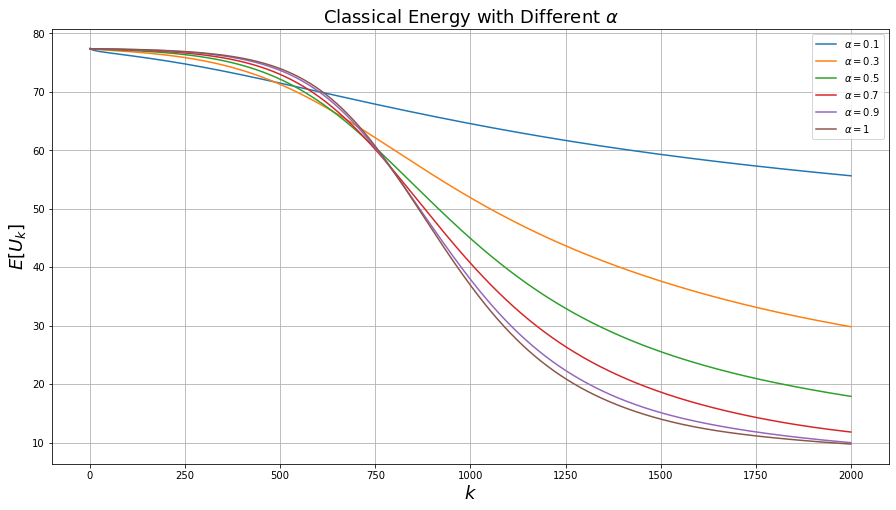

In [50]:
alpha_list = [0.1, 0.3, 0.5,  0.7, 0.9, 1]
BC = 'periodic'

L = 10
eps = 0.1

Nx = 2**5
x = np.linspace(-L/2, L/2, Nx) 
y = np.linspace(-L/2, L/2, Nx)

h = L / (Nx - 1)
dt = 5*1e-3
iter_max = 2000

u = 0.05*(2*np.random.rand(Nx-1, Nx-1)-1)
u0 = u.flatten()


# set the discrete laplacian
Lap = set_Laplacian2D(Nx, h, BC)

if BC == 'periodic':
    x = x[:-1]
    y = y[:-1]
    I = diags(np.ones((Nx-1)**2), shape=((Nx-1)**2, (Nx-1)**2))
elif BC == 'neumann':
    I = diags(np.ones((Nx)**2), shape=((Nx)**2, (Nx)**2))

# set the 2D mesh grid by x and y
X, Y = np.meshgrid(x, y)

# the dicitionary to storage the different fractional order results
data_dict = {}

# set a figure to plot the energy in different alpha
fig = plt.figure(figsize=(15,8))

for alpha in alpha_list:
    print(f"alpha: {alpha}")
    energy_list = [compute_classical_energy(u0, eps, h)]
    u_historyArray = u0
    u = u0
        
        
    if alpha == 1:
        # solved by classical allen cahn
        H = (2+1/dt) * I - eps**2 * Lap
        
        for i in range(iter_max):
                b = (3+1/dt)*u - u**3
                u = spsolve(H, b)
                energy = compute_classical_energy(u, eps, h)
                energy_list.append(energy)
                u_historyArray = np.vstack([u_historyArray, u])
    else:
        GL_coef = set_coef(iter_max, alpha, 'GL') / dt**alpha
        H = (GL_coef[0]+2) * I - eps**2 * Lap
            
        for i in range(iter_max):
            if i == 0: # first iteration u_1
                b =  (3 + GL_coef[0])*u - u**3
                u = spsolve(H, b)
            else:
                u_nonlocalDiff = np.flipud(u_historyArray[1:]-u0)
                u_nonlocal = GL_coef[1:i+1].dot(u_nonlocalDiff)
        
                b = 3*u - u**3 - u_nonlocal + GL_coef[0]*u0
                u = spsolve(H, b)
            
            u_historyArray = np.vstack([u_historyArray, u])
            energy = compute_classical_energy(u, eps, h)
            energy_list.append(energy)

    plt.plot(energy_list)
    data_dict[alpha] = u_historyArray
    
plt.legend([r"$\alpha=$"+f"{alpha}" for alpha in alpha_list])
plt.title(r"Classical Energy with Different $\alpha$", fontsize=18)
plt.xlabel(r"$k$", fontsize=18)
plt.ylabel(r"$E[U_{k}]$", fontsize=18)
plt.grid()
plt.show()

In [11]:
plt.figure(figsize=(12,5))
plt.contourf(X,Y, np.reshape(data_dict[0.9][-1], (Nx-1,Nx-1)), cmap="turbo")
plt.colorbar()
plt.title('coarsening')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

NameError: name 'X' is not defined

<Figure size 720x216 with 0 Axes>

In [4]:
rootPath = Path('./data/') / 'coarsening' / 'others'

dataPath = [folder for folder in rootPath.iterdir() \
            if not folder.name[0].startswith('.')]

alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
alpha: 1


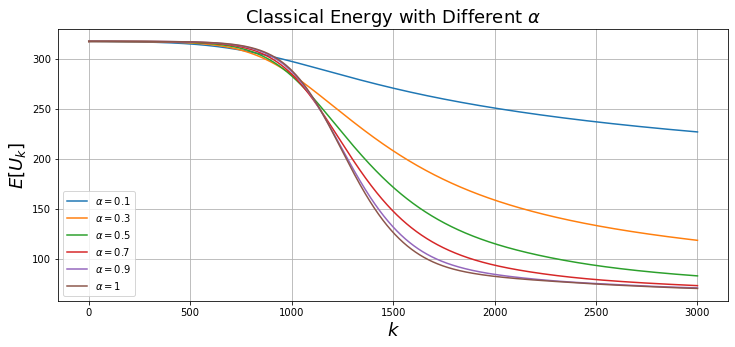

In [10]:
alpha_list = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
fig = plt.figure(figsize=(12,5))

for alpha in alpha_list:
    energy_list = []
    print(f"alpha: {alpha}")
    u_hist = np.load(dataPath[0] / f'L1_{alpha}_coarsening.npy')
    for i in range(3001):
        energy_list.append(compute_classical_energy(u_hist[i], 0.1, 10/127))
    plt.plot(energy_list)

plt.legend([r"$\alpha=$"+f"{alpha}" for alpha in alpha_list])
plt.title(r"Classical Energy with Different $\alpha$", fontsize=18)
plt.xlabel(r"$k$", fontsize=18)
plt.ylabel(r"$E[U_{k}]$", fontsize=18)
plt.grid()
plt.show()